### Import modules

In [224]:
import pandas as pd
import json
import seaborn as sns
import datetime
import time
from matplotlib import pyplot as plt

### Loading dataset into dataframe

In [108]:
list_transactions = []
with open('transactions.txt') as fp:
    for line in fp:
        list_transactions.append(json.loads(line))

df = pd.DataFrame(list_transactions)

### Structure of the data

There are **786,363** records and **29** fields in the dataset.

In [109]:
#number of records and fields in the dataframe
print(df.shape)
print(df.columns)

(786363, 29)
Index(['accountNumber', 'accountOpenDate', 'acqCountry', 'availableMoney',
       'cardCVV', 'cardLast4Digits', 'cardPresent', 'creditLimit',
       'currentBalance', 'currentExpDate', 'customerId',
       'dateOfLastAddressChange', 'echoBuffer', 'enteredCVV',
       'expirationDateKeyInMatch', 'isFraud', 'merchantCategoryCode',
       'merchantCity', 'merchantCountryCode', 'merchantName', 'merchantState',
       'merchantZip', 'posConditionCode', 'posEntryMode', 'posOnPremises',
       'recurringAuthInd', 'transactionAmount', 'transactionDateTime',
       'transactionType'],
      dtype='object')


### Summary statistics
Lets see a quick statistic summary of the data

In [110]:
df.describe()

,availableMoney,creditLimit,currentBalance,transactionAmount
count,786363.000000,786363.000000,786363.000000,786363.000000
mean,6250.725369,10759.464459,4508.739089,136.985791
std,8880.783989,11636.174890,6457.442068,147.725569
min,-1005.630000,250.000000,0.000000,0.000000
25%,1077.420000,5000.000000,689.910000,33.650000
50%,3184.860000,7500.000000,2451.760000,87.900000
75%,7500.000000,15000.000000,5291.095000,191.480000
max,50000.000000,50000.000000,47498.810000,2011.540000


Now list the unique values for each field in the dataframe as **(fieldname, number of unique values, unique values)**

In [111]:
for col in df:
    print((col, df[col].nunique(), df[col].unique()))
    print()

('accountNumber', 5000, array(['737265056', '830329091', '574788567', ..., '899818521',
       '638498773', '732852505'], dtype=object))

('accountOpenDate', 1820, array(['2015-03-14', '2015-08-06', '2015-10-13', ..., '2009-08-17',
       '2008-04-15', '2012-08-23'], dtype=object))

('acqCountry', 5, array(['US', '', 'CAN', 'MEX', 'PR'], dtype=object))

('availableMoney', 521916, array([ 5000.  ,  4990.63,  4959.25, ..., 48766.15, 48716.72, 48666.83]))

('cardCVV', 899, array(['414', '486', '885', '206', '579', '205', '640', '773', '483',
       '438', '808', '240', '736', '779', '853', '726', '142', '418',
       '310', '436', '557', '264', '402', '570', '307', '665', '781',
       '737', '692', '519', '717', '995', '311', '356', '197', '676',
       '647', '866', '461', '551', '529', '225', '671', '581', '963',
       '593', '215', '956', '655', '209', '128', '258', '788', '981',
       '236', '161', '151', '277', '965', '449', '930', '317', '798',
       '220', '296', '395', '822', 

('customerId', 5000, array(['737265056', '830329091', '574788567', ..., '899818521',
       '638498773', '732852505'], dtype=object))

('dateOfLastAddressChange', 2184, array(['2015-03-14', '2015-08-06', '2015-10-13', ..., '2009-08-17',
       '2008-04-15', '2012-08-23'], dtype=object))

('echoBuffer', 1, array([''], dtype=object))

('enteredCVV', 976, array(['414', '486', '885', '206', '579', '539', '205', '265', '640',
       '670', '240', '630', '140', '679', '773', '173', '783', '713',
       '774', '483', '438', '433', '741', '808', '736', '779', '250',
       '440', '260', '746', '853', '726', '147', '418', '142', '172',
       '310', '436', '557', '264', '402', '202', '505', '570', '307',
       '470', '665', '781', '737', '337', '734', '692', '519', '717',
       '995', '311', '356', '350', '915', '197', '676', '647', '866',
       '461', '551', '555', '529', '329', '225', '255', '625', '671',
       '581', '963', '903', '593', '215', '956', '655', '209', '203',
       '269', '

('merchantCountryCode', 5, array(['US', 'CAN', '', 'PR', 'MEX'], dtype=object))

('merchantName', 2490, array(['Uber', 'AMC #191138', 'Play Store', ..., 'ATT #141119',
       'EZ Wireless #200746', 'Runners #747070'], dtype=object))

('merchantState', 1, array([''], dtype=object))

('merchantZip', 1, array([''], dtype=object))

('posConditionCode', 4, array(['01', '08', '99', ''], dtype=object))

('posEntryMode', 6, array(['02', '09', '05', '80', '90', ''], dtype=object))

('posOnPremises', 1, array([''], dtype=object))

('recurringAuthInd', 1, array([''], dtype=object))

('transactionAmount', 66038, array([ 98.55,  74.51,   7.47, ..., 482.13, 451.71, 624.07]))

('transactionDateTime', 776637, array(['2016-08-13T14:27:32', '2016-10-11T05:05:54',
       '2016-11-08T09:18:39', ..., '2016-12-27T15:46:24',
       '2016-12-29T00:30:55', '2016-12-30T20:10:29'], dtype=object))

('transactionType', 4, array(['PURCHASE', 'ADDRESS_VERIFICATION', 'REVERSAL', ''], dtype=object))



The fields **echoBuffer, merchantCity, merchantState, merchantZip, posOnPremises, recurringAuthInd** contain **null value** only. We will drop these fields from the dataframe.

In [112]:
df.drop(columns=['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd' ], axis=1, inplace=True)

Lets now count **null values** for each of remaining fields.

In **acqCountry, merchantCountryCode, posConditionCode , posEntryMode, transactionType** fields there are 4562, 724, 409, 4054, 698 null values respectively.

In [140]:
for col in df:
    if df[col].dtype == 'object' and df[df[col] == ''].shape[0] > 0: #fields where data type is string
        print(col, df[df[col] == ''].shape[0])
    elif df[col].isna().sum() > 0:
        print(col, df[col].isna().sum())

acqCountry 4562
merchantCountryCode 724
posConditionCode 409
posEntryMode 4054
transactionType 698


### Histogram of the Processed Amounts of Each Transaction

The distribution of processed amounts of transactions is **right skewed**, that means it is not symmetric around the mean. The mean is greater than the median. Also notice that the tail of the distribution on the right hand (positive) side is longer than on the left hand side.

My hypothesis is customers use credit card mostly for small transactions.

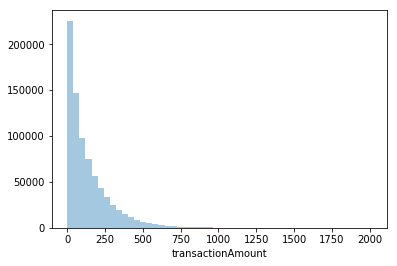

In [139]:
sns.distplot(df['transactionAmount'], hist = True, kde = False)
plt.show()

### Duplicate Transactions

In [144]:
df[df['transactionType'] == 'REVERSAL']

,accountNumber,accountOpenDate,acqCountry,availableMoney,cardCVV,cardLast4Digits,cardPresent,creditLimit,currentBalance,currentExpDate,...,expirationDateKeyInMatch,isFraud,merchantCategoryCode,merchantCountryCode,merchantName,posConditionCode,posEntryMode,transactionAmount,transactionDateTime,transactionType
39,574788567,2015-10-13,US,2200.98,206,8522,True,2500.0,299.02,10/2021,...,False,False,auto,US,Convenient Tire,01,09,215.13,2016-05-24T01:38:03,REVERSAL
73,574788567,2015-10-13,US,2432.72,579,4219,True,2500.0,67.28,10/2022,...,False,False,auto,US,Eazy Repair,01,05,3.87,2016-10-07T10:23:57,REVERSAL
101,924729945,2014-07-25,US,49831.43,205,9459,False,50000.0,168.57,11/2024,...,False,False,online_retail,US,discount.com,01,05,168.57,2016-10-19T14:01:45,REVERSAL
133,984504651,2015-07-27,US,46367.41,640,8332,False,50000.0,3632.59,08/2028,...,False,False,health,US,Planet Fitness #849960,01,05,450.74,2016-01-16T09:53:15,REVERSAL
156,984504651,2015-07-27,US,41909.30,640,8332,True,50000.0,8090.70,12/2031,...,False,False,entertainment,US,AMC #724446,01,09,81.73,2016-01-25T20:39:15,REVERSAL
181,984504651,2015-07-27,US,38090.70,640,8332,True,50000.0,11909.30,11/2025,...,False,False,food,US,1st Sandwitch Bar #801388,01,09,83.64,2016-02-04T00:14:42,REVERSAL
196,984504651,2015-07-27,US,36667.94,640,8332,False,50000.0,13332.06,01/2022,...,False,False,health,US,NYSC #91039,01,05,34.73,2016-02-11T20:32:35,REVERSAL
200,984504651,2015-07-27,US,36452.49,640,8332,False,50000.0,13547.51,03/2028,...,False,False,health,US,Golds Gym #747443,01,09,34.92,2016-02-12T05:10:49,REVERSAL
201,984504651,2015-07-27,US,36487.41,640,8332,False,50000.0,13512.59,07/2025,...,False,False,health,US,WSC #653684,01,02,53.44,2016-02-12T12:47:03,REVERSAL
237,984504651,2015-07-27,US,31365.68,640,8332,True,50000.0,18634.32,12/2032,...,False,False,food,US,34th Pub,01,02,239.96,2016-02-27T21:30:09,REVERSAL


In [225]:
dfUniqueTransaction = df[['accountNumber', 'merchantName', 'transactionType', 'transactionAmount', 'transactionDateTime']]
dfPurchase = dfUniqueTransaction[df['transactionType'] == 'PURCHASE']
dfReversal = dfUniqueTransaction[df['transactionType'] == 'REVERSAL']

totalReversalDuplicates = 0

dfPurchaseSameAccount = None
prevAccountNumber = None
start = time.time()
for _, row in dfReversal.iterrows():
    if row['accountNumber'] != prevAccountNumber:
        dfPurchaseSameAccount = dfPurchase[dfPurchase['accountNumber'] == row['accountNumber']]
        prevAccountNumber = row['accountNumber']
    if ((dfPurchaseSameAccount['transactionAmount'] == row['transactionAmount']) & (dfPurchaseSameAccount['merchantName'] == row['merchantName']) & (row['transactionDateTime'] > dfPurchaseSameAccount['transactionDateTime'])).any():
        totalReversalDuplicates += 1

print('Total number of reversal duplicates: ', totalReversalDuplicates)
print(time.time() - start)

Total number of reversal duplicates:  17759
422.1883957386017


In [200]:
df.groupby('accountNumber').count()

,accountOpenDate,acqCountry,availableMoney,cardCVV,cardLast4Digits,cardPresent,creditLimit,currentBalance,currentExpDate,customerId,...,expirationDateKeyInMatch,isFraud,merchantCategoryCode,merchantCountryCode,merchantName,posConditionCode,posEntryMode,transactionAmount,transactionDateTime,transactionType
accountNumber,,,,,,,,,,,,,,,,,,,,,
100088067,75,75,75,75,75,75,75,75,75,75,...,75,75,75,75,75,75,75,75,75,75
100108752,18,18,18,18,18,18,18,18,18,18,...,18,18,18,18,18,18,18,18,18,18
100328049,103,103,103,103,103,103,103,103,103,103,...,103,103,103,103,103,103,103,103,103,103
100663626,31,31,31,31,31,31,31,31,31,31,...,31,31,31,31,31,31,31,31,31,31
100737756,178,178,178,178,178,178,178,178,178,178,...,178,178,178,178,178,178,178,178,178,178
100947057,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
101132326,68,68,68,68,68,68,68,68,68,68,...,68,68,68,68,68,68,68,68,68,68
101339369,37,37,37,37,37,37,37,37,37,37,...,37,37,37,37,37,37,37,37,37,37
101376441,65,65,65,65,65,65,65,65,65,65,...,65,65,65,65,65,65,65,65,65,65
